# CNN Encoder + LSTM Decoder

In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [3]:
# import our command line tools
from sketch_rnn_train_cnn_tf import *
from model_cnn_tf import *
from utils_cnn import *
from rnn import *
from cnn_tf import *

In [6]:
# HELPER FUNCTION
def draw_strokes(data, color="black", doGradient=False, endColor="black", factor=0.2, svg_filename = 'svg/sample.svg'):
    tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        #print(x)
        #print(y)
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    np.save("data_tester.npy",data)
    the_color = color
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))
    
# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]

  #for each reconstruction
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  print(seq_len)
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]
def encode_cnn(input_ims):
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_ims: [input_ims]})[0]
#latent vector to stroke
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m, _, _ = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor=factor)
  return strokes

## Multi-Class Models

In [7]:
model_dir = 'gen/'
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model gen/vector-70000.
INFO:tensorflow:Restoring parameters from gen/vector-70000


In [8]:
# load datasets
data_dir = 'datasets/'
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)
[train_ims, valid_ims, test_ims] = load_env_ims(data_dir, model_dir)

INFO:tensorflow:Loaded 45000/2500/2500 from ear_cnn.npz
INFO:tensorflow:Loaded 45000/2500/2500 from eye_cnn.npz
INFO:tensorflow:Loaded 45000/2500/2500 from mouth_cnn.npz
INFO:tensorflow:Loaded 45000/2500/2500 from nose_cnn.npz
INFO:tensorflow:Dataset combined: 200000 (180000/10000/10000), avg len 36
INFO:tensorflow:model_params.max_seq_len 125.
total images <= max_seq_len is 180000
total images <= max_seq_len is 10000
total images <= max_seq_len is 10000
INFO:tensorflow:normalizing_scale_factor 45.8366.
INFO:tensorflow:Loaded 45000/2500/2500 from ear_cnn.npy
INFO:tensorflow:Loaded 45000/2500/2500 from eye_cnn.npy
INFO:tensorflow:Loaded 45000/2500/2500 from mouth_cnn.npy
INFO:tensorflow:Loaded 45000/2500/2500 from nose_cnn.npy


8814


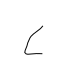

In [532]:
# First random samples
#i = np.random.randint(7500,10000)
i = 8814
#i = np.random.randint(2500,5000)
print(i)
stroke_0 = np.copy(test_set.strokes[i])
draw_strokes(stroke_0)
im_0 = np.copy(test_ims[i,:,:]).astype('float32')
z_0 = encode_cnn(im_0)


9303


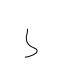

In [537]:
# Second random sample
#i = np.random.randint(7500,10000)
i = np.random.randint(7500,10000)
#i = 6555
print(i)
stroke_1 = np.copy(test_set.strokes[i])
draw_strokes(stroke_1)
im_1 = np.copy(test_ims[i,:,:]).astype('float32')
z_1 = encode_cnn(im_1)

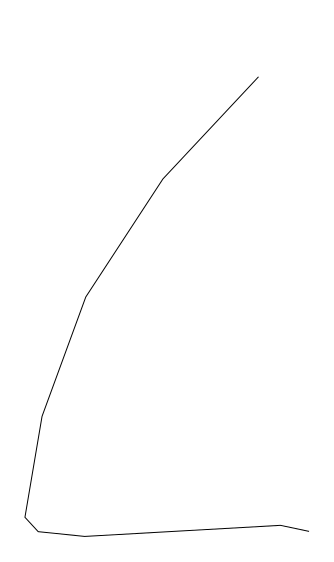

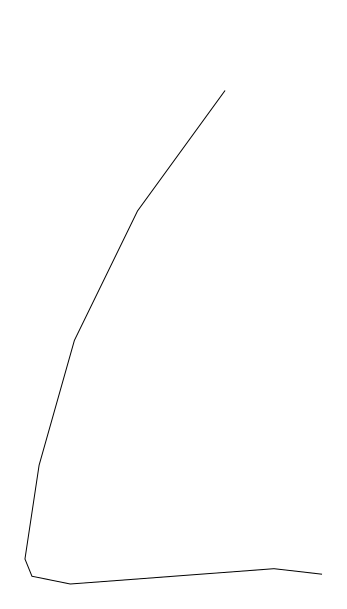

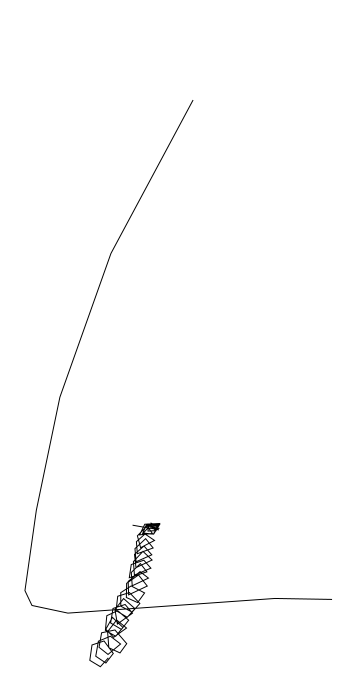

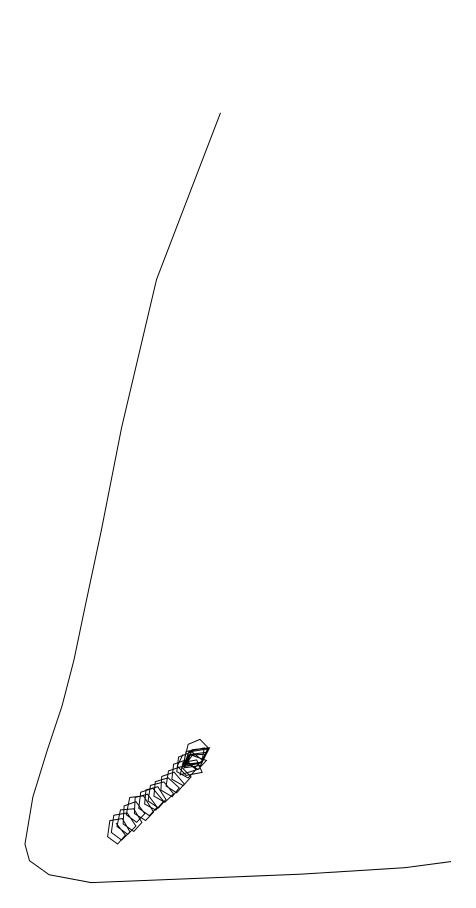

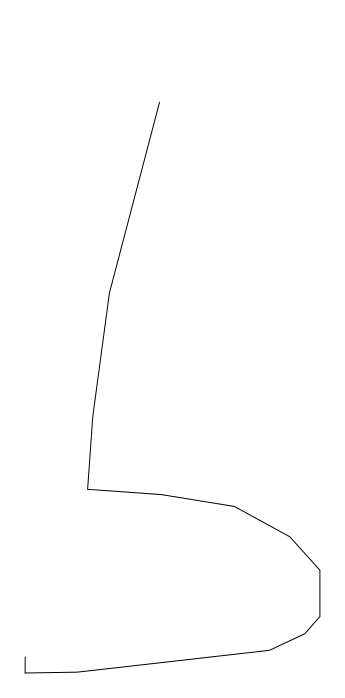

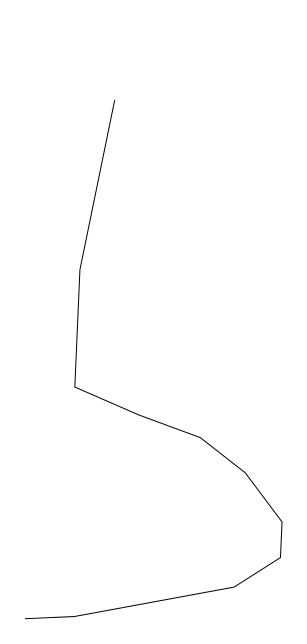

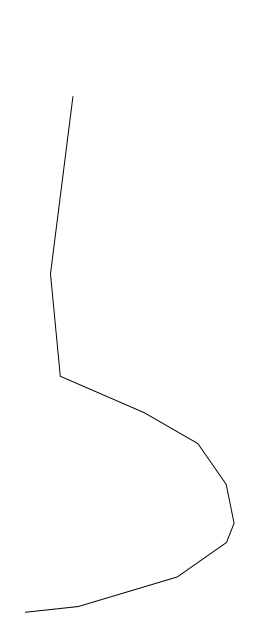

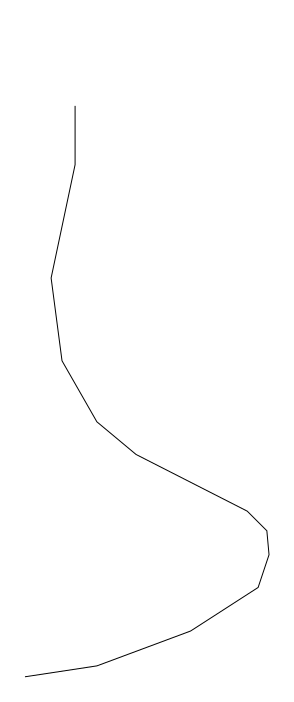

In [538]:
# interpolation
z_list = [] # interpolate spherically between z0 and z1
N = 8
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))

# for every latent vector in z_list, sample a vector image
reconstructions = []
reconstructions.append([stroke_0, [0, 0]])
outfile = "nose/nose9_"
for i in range(1,N):
    decoded = decode(z_list[i],draw_mode=False)
    draw_strokes(decoded,svg_filename = outfile+str(i)+".svg",factor=0.01)
    #reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])
draw_strokes(stroke_1,svg_filename = outfile+str(i+1)+".svg",factor=0.01)
#reconstructions.append([stroke_1, [0, N]])

#stroke_grid = make_grid_svg(reconstructions)
#draw_strokes(stroke_grid,factor=0.2, svg_filename = 'svg/cnn_interp_1.svg')